Saving PRICE_AND_DEMAND_201801_NSW1.csv to PRICE_AND_DEMAND_201801_NSW1 (1).csv


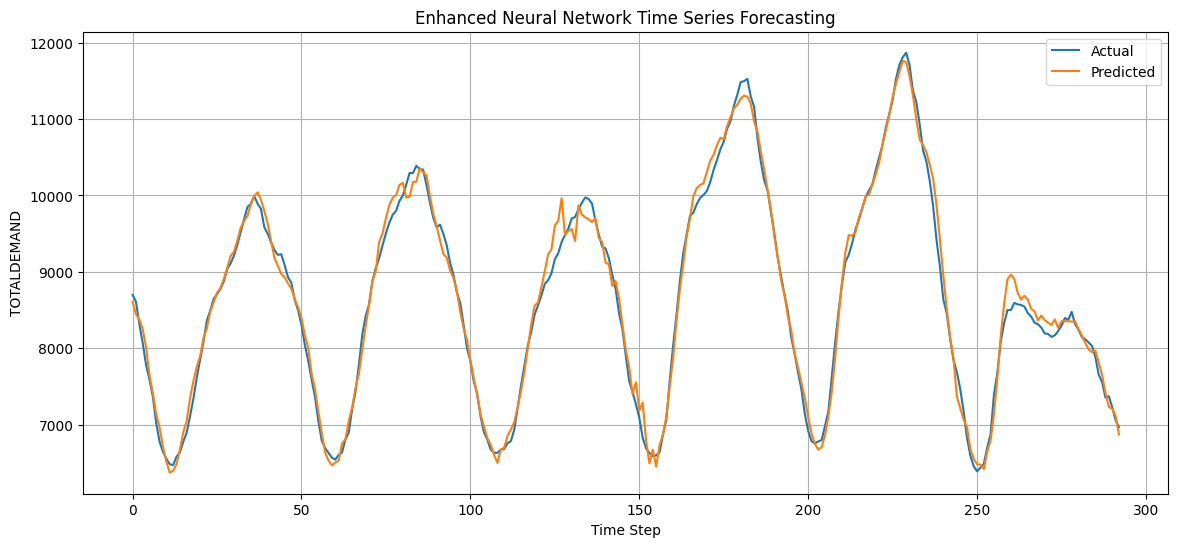

MSE: 22624.19, MAE: 115.89


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from google.colab import files
import io

# Upload file
uploaded = files.upload()
for fn in uploaded.keys():
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))

# Parse datetime and set index
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
df.set_index('SETTLEMENTDATE', inplace=True)

# Keep relevant columns
data = df[['TOTALDEMAND', 'RRP']].dropna()

# Feature engineering: lag features and time features
for lag in range(1, 25):
    data[f'TOTALDEMAND_LAG_{lag}'] = data['TOTALDEMAND'].shift(lag)
    data[f'RRP_LAG_{lag}'] = data['RRP'].shift(lag)

data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

# Drop rows with NaNs (from lag)
data.dropna(inplace=True)

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# Prepare input and target
X = scaled[:, 1:]  # Exclude current TOTALDEMAND as input
y = scaled[:, 0]   # Predict TOTALDEMAND

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build deeper neural network
model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Rescale predictions and actuals
total_demand_index = 0
y_test_rescaled = scaler.inverse_transform(np.hstack([y_test.reshape(-1,1), X_test]))[:, total_demand_index]
y_pred_rescaled = scaler.inverse_transform(np.hstack([y_pred.reshape(-1,1), X_test]))[:, total_demand_index]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled[:300], label='Actual')
plt.plot(y_pred_rescaled[:300], label='Predicted')
plt.title("Enhanced Neural Network Time Series Forecasting")
plt.xlabel("Time Step")
plt.ylabel("TOTALDEMAND")
plt.legend()
plt.grid(True)
plt.show()

# Metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')
